In [1]:
import random
import re
import warnings

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import hinge_loss
from sklearn.pipeline import Pipeline
from torchtext.datasets import IMDB
import time

warnings.filterwarnings("ignore")

In [2]:
class IMDBSentimentAnalyzer:
    def __init__(self, max_features=5000):
        self.vectorizer = TfidfVectorizer(max_features=max_features)
        self.model = SGDClassifier(loss='hinge', max_iter=1, warm_start=True, learning_rate='constant', eta0=0.001)
        self.pipeline = Pipeline([
            ('tfidf', self.vectorizer),
            ('sgd', self.model)
        ])
        self.loss_history = []
        self.accuracy_history = []

    @staticmethod
    def simple_preprocess(text):
        text = re.sub(r"[^a-zA-Z]", " ", text)
        text = text.lower()
        return text

    @staticmethod
    def load_and_preprocess_imdb():
        train_iter, test_iter = IMDB(split=('train', 'test'))
        train_data = [(IMDBSentimentAnalyzer.simple_preprocess(text), label) for label, text in train_iter]
        test_data = [(IMDBSentimentAnalyzer.simple_preprocess(text), label) for label, text in test_iter]
        return train_data, test_data

    @staticmethod
    def load_preprocess_dmsc(all_content_list):
        random.shuffle(all_content_list)
        train_data = all_content_list[0:int(len(all_content_list) * 0.7)]
        test_data = all_content_list[int(len(all_content_list) * 0.7):]
        return train_data, test_data

    def train(self, train_data, epochs=30):
        train_reviews, train_labels = zip(*train_data)
        y_train = train_labels
        patten = 'Epoch: %d   [===========]  cost: %.2fs;  loss: %.4f;  train acc: %.4f;  precision:%.4f;  recall:%.4f;  f1:%.4f;'
        for epoch in range(epochs):
            start = time.time()
            self.pipeline.fit(train_reviews, y_train)
            y_pred = self.pipeline.predict(train_reviews)
            accuracy = accuracy_score(y_train, y_pred)
            self.accuracy_history.append(accuracy)
            precision, recall, f1, _ = precision_recall_fscore_support(y_train, y_pred, average='binary')
            # 计算损失
            y_decision = self.pipeline.decision_function(train_reviews)
            hinge_loss_v = hinge_loss(y_train,y_decision)
            self.loss_history.append(hinge_loss_v)
            end = time.time()
            print("End of epoch %d" % epoch)
            print(patten % (epoch, end - start, hinge_loss_v, accuracy, precision, recall, f1))

    def evaluate(self, test_data):
        test_reviews, test_labels = zip(*test_data)
        y_test = test_labels
        y_pred = self.pipeline.predict(test_reviews)
        accuracy = accuracy_score(y_test, y_pred)

        # Calculate AUC-ROC
        fpr, tpr, thresholds = roc_curve(y_test, y_pred)
        roc_auc = auc(fpr, tpr)
        # Plot AUC-ROC curve
        plt.figure()
        lw = 2
        plt.plot(fpr, tpr, color='darkorange', lw=lw, label=f'AUC = {roc_auc:.2f}')
        plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver Operating Characteristic Curve')
        plt.legend(loc="lower right")

        # Confusion matrix
        cm = confusion_matrix(y_test, y_pred)
        labels11 = ['negative', 'active']
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels11)
        disp.plot(cmap="Blues", values_format='')
        plt.show()
        return accuracy

    def plot_loss(self):
        sns.set(style='darkgrid')
        plt.figure(figsize=(10, 7))
        x = list(range(len(self.loss_history)))
        plt.plot(x, self.loss_history, alpha=0.9, linewidth=2, label='train loss')
        plt.xlabel('Epoch')
        plt.ylabel('loss')
        plt.legend(loc='best')
        plt.show()

    def plot_acc(self):
        sns.set(style='darkgrid')
        plt.figure(figsize=(10, 7))
        x = list(range(len(self.accuracy_history)))
        plt.plot(x, self.accuracy_history, alpha=0.9, linewidth=2, label='train acc')
        plt.xlabel('Epoch')
        plt.ylabel('Acc')
        plt.legend(loc='best')
        plt.show()

End of epoch 0
Epoch: 0   [===========]  cost: 8.21s;  loss: 0.9565;  train acc: 0.6976;  precision:0.8970;  recall:0.4466;  f1:0.5963;
End of epoch 1
Epoch: 1   [===========]  cost: 8.08s;  loss: 0.9132;  train acc: 0.6976;  precision:0.8970;  recall:0.4466;  f1:0.5963;
End of epoch 2
Epoch: 2   [===========]  cost: 8.05s;  loss: 0.8699;  train acc: 0.6976;  precision:0.8970;  recall:0.4466;  f1:0.5963;
End of epoch 3
Epoch: 3   [===========]  cost: 8.17s;  loss: 0.8274;  train acc: 0.7001;  precision:0.8932;  recall:0.4545;  f1:0.6024;
End of epoch 4
Epoch: 4   [===========]  cost: 8.15s;  loss: 0.7886;  train acc: 0.7251;  precision:0.8797;  recall:0.5216;  f1:0.6549;
End of epoch 5
Epoch: 5   [===========]  cost: 7.91s;  loss: 0.7528;  train acc: 0.7605;  precision:0.8474;  recall:0.6354;  f1:0.7262;
End of epoch 6
Epoch: 6   [===========]  cost: 7.81s;  loss: 0.7183;  train acc: 0.7824;  precision:0.8094;  recall:0.7389;  f1:0.7725;
End of epoch 7
Epoch: 7   [===========]  cost: 8

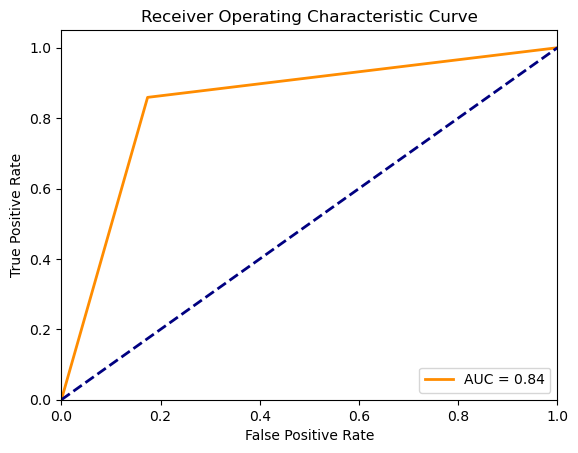

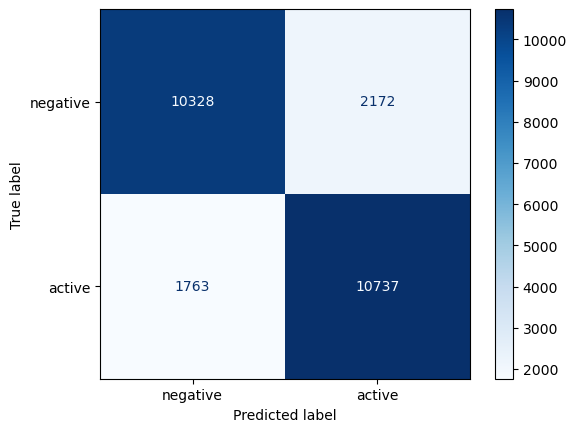

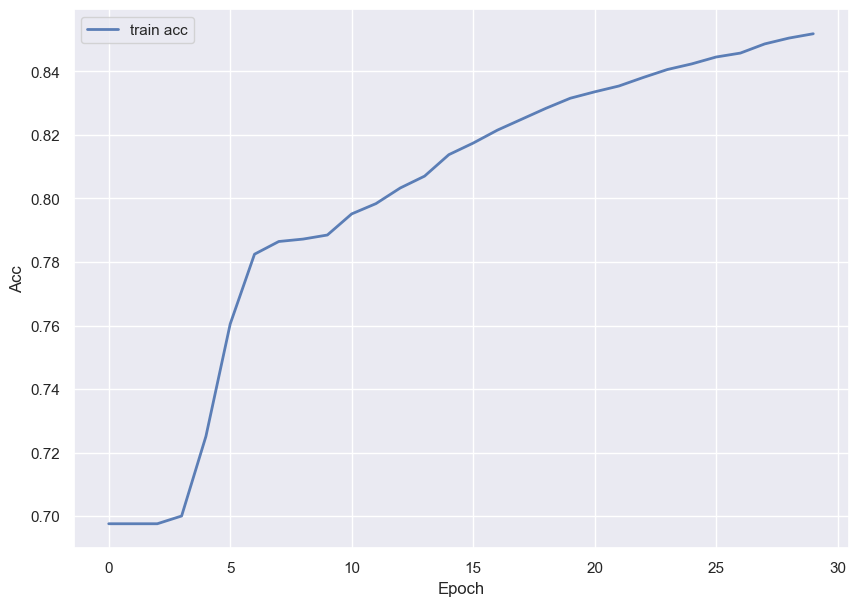

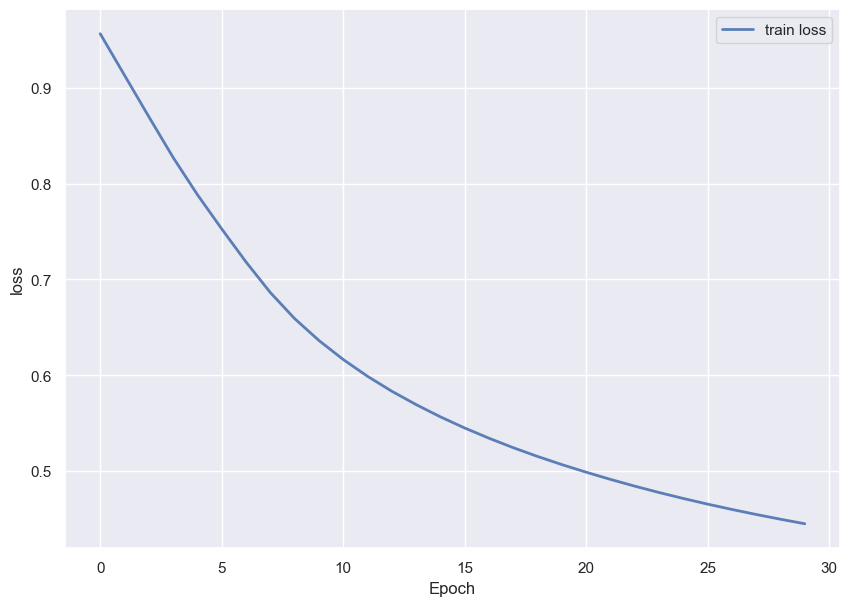

In [3]:
ana = IMDBSentimentAnalyzer()
train_data, test_data = ana.load_and_preprocess_imdb()
train_data = [(a, 1 if b == 2 else 0) for a, b in train_data]
test_data = [(a, 1 if b == 2 else 0) for a, b in test_data]
ana.train(train_data)
ana.evaluate(test_data)
ana.plot_acc()
ana.plot_loss()

End of epoch 0
Epoch: 0   [===========]  cost: 8.50s;  loss: 0.4471;  train acc: 0.7765;  precision:0.7764;  recall:0.9993;  f1:0.8739;
End of epoch 1
Epoch: 1   [===========]  cost: 8.64s;  loss: 0.4459;  train acc: 0.7770;  precision:0.7769;  recall:0.9992;  f1:0.8741;
End of epoch 2
Epoch: 2   [===========]  cost: 8.53s;  loss: 0.4454;  train acc: 0.7774;  precision:0.7774;  recall:0.9988;  f1:0.8743;
End of epoch 3
Epoch: 3   [===========]  cost: 8.37s;  loss: 0.4450;  train acc: 0.7774;  precision:0.7774;  recall:0.9988;  f1:0.8743;
End of epoch 4
Epoch: 4   [===========]  cost: 8.66s;  loss: 0.4449;  train acc: 0.7774;  precision:0.7774;  recall:0.9987;  f1:0.8743;
End of epoch 5
Epoch: 5   [===========]  cost: 9.02s;  loss: 0.4448;  train acc: 0.7774;  precision:0.7774;  recall:0.9987;  f1:0.8743;
End of epoch 6
Epoch: 6   [===========]  cost: 8.85s;  loss: 0.4446;  train acc: 0.7774;  precision:0.7774;  recall:0.9987;  f1:0.8743;
End of epoch 7
Epoch: 7   [===========]  cost: 8

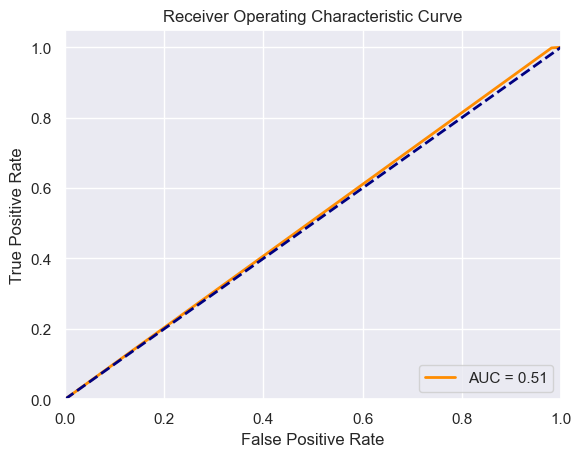

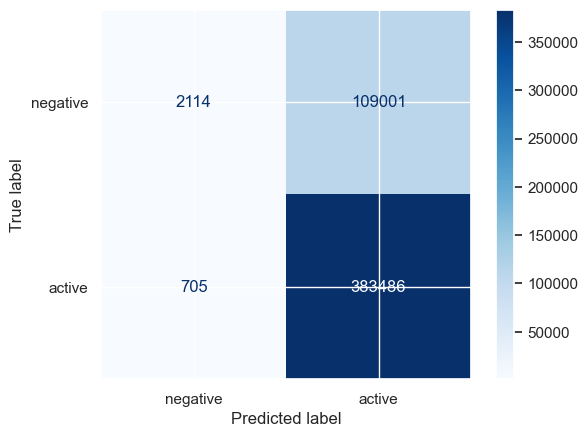

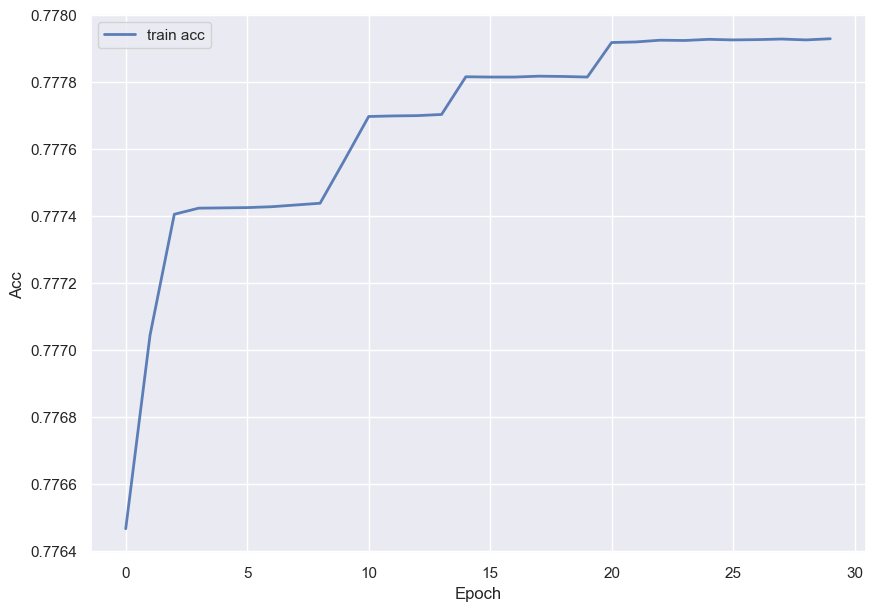

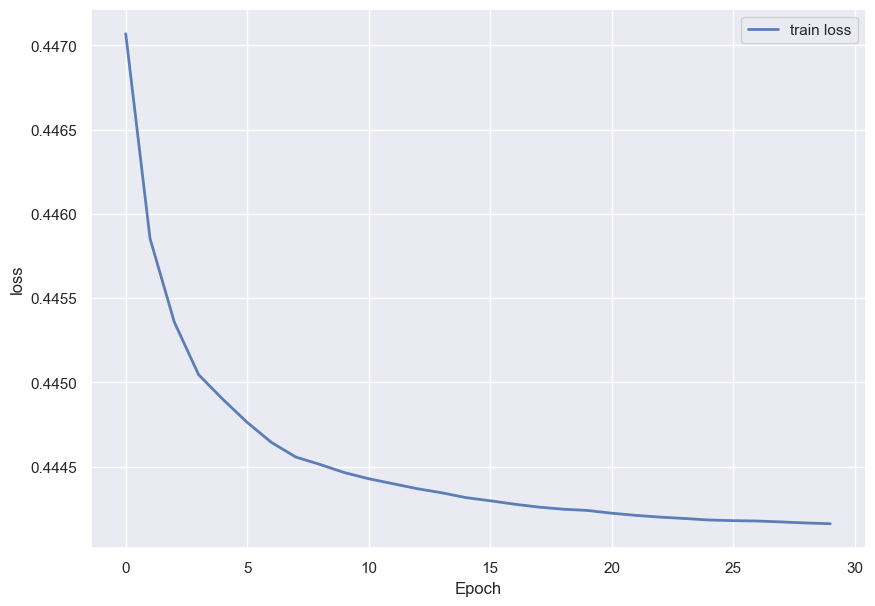

In [4]:
f = open('dmsc.txt',encoding='utf-8')
all_content_list = []
for line in f.readlines():
    line_list = line.strip().split(' ')
    try:
        label = line_list[0].split('\t')[0]
        content = line_list[1]
        if label == '1':
            all_content_list.append((content, 'pos'))
        else:
            all_content_list.append((content, 'neg'))
    except:
        pass
ana1 = IMDBSentimentAnalyzer()
all_content_list = [(ana1.simple_preprocess(item[0]), item[1]) for item in all_content_list]
train_data_1, test_data_1 = ana1.load_preprocess_dmsc(all_content_list)
train_data_1 = [(a, 1 if b == 'pos' else 0) for a, b in train_data_1]
test_data_1 = [(a, 1 if b == 'pos' else 0) for a, b in test_data_1]
ana1.train(train_data_1)
ana1.evaluate(test_data_1)
ana1.plot_acc()
ana1.plot_loss()